In [1]:
%run ../macro_tQ.py
import sys
sys.path.append('../')
import macro_tQ as tQ

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def random_linear_oracle(n):  #n es la longitud de la cadena a oculta

    import random, string
    a = ''.join(random.choices(['0','1'], k=n))
    print('cadena oculta=',a)  
    qc = QuantumCircuit(n+1) # el ultimo registro es la salida |f(x)> = |a.x>

    
    for i, ai in enumerate(reversed(a)):  # ponemos reversed para usar el convenio de qiskit
        if ai == '1':
            qc.cx(i,n)    
    return qc

random_linear_oracle(4).draw()
    

cadena oculta= 1101


q_0: ──■────────────
       │            
q_1: ──┼────────────
       │            
q_2: ──┼────■───────
       │    │       
q_3: ──┼────┼────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐
q_4: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘

In [3]:
def BV_circuit(linear_oracle):
    n = linear_oracle.num_qubits - 1
    qreg = QuantumRegister(n+1)
    creg = ClassicalRegister(n)
    qc = QuantumCircuit(qreg,creg)

    'generamos máxima superposición'
    qc.h(qreg)

    'Ponemos el último qubit en el estado |->'
    qc.z(qreg[-1])
     
    'añadimos el oráculo lineal con la cadena oculta'
    qc.append(linear_oracle.to_gate(),qreg[:])   
 
    'generamos interferencias'
    qc.h(qreg[0:-1])

    'medimos'
    qc.measure(qreg[0:-1],creg)
    return qc

cadena oculta= 1110


/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


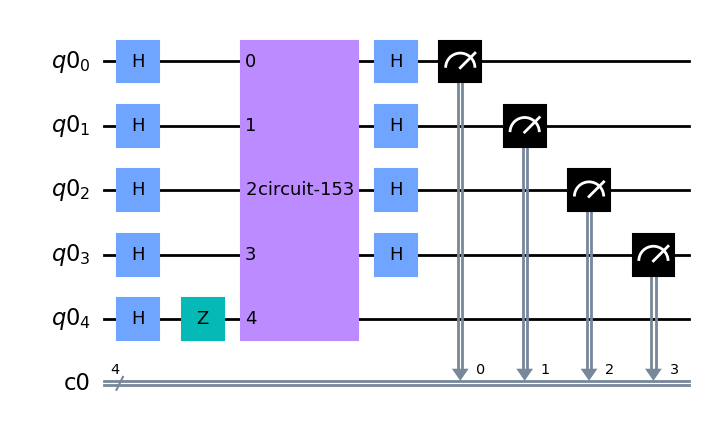

In [4]:
n = 4
linear_oracle = random_linear_oracle(n)
BV_qc = BV_circuit(linear_oracle)

BV_qc.draw(output = 'mpl')

In [5]:
from qiskit.primitives import Sampler
shots = 1
dist = Sampler().run(BV_qc,shots=shots).result().quasi_dists[0]

tQ.dist2counts(dist,n,shots)

{'1110': 1}

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def simon_circuit(oracle):
    n = int(oracle.num_qubits/2)
    qr_in = QuantumRegister(n, name='x')
    qr_out = QuantumRegister(n, name='f(x)')
    cr = ClassicalRegister(n, name='meas')    

    'Construimos el circuito'
    qc = QuantumCircuit(qr_in, qr_out, cr, name='q')   
    qc.h(qr_in)

    'creamos el oráculo, lo transformamos en una puerta y lo añadimos al circuito' 
    simon_oracle_gate = oracle.to_gate()
    qc.append(simon_oracle_gate,qr_in[:]+qr_out[:])    

    'Medimos el registro de los cúbits de |f(x)>  este paso se puede omitir, ¡compruébalo! '
#    qc.measure(qr_out, cr)
#    qc.barrier()

    'Volvemos a aplicar la puerta de Walsh-Hadamard al primer registro'
    qc.h(qr_in)
    qc.barrier()

    'Finalmente medimos el registro de los inputs |x>'
    qc.measure(qr_in, cr) 
    
    return qc

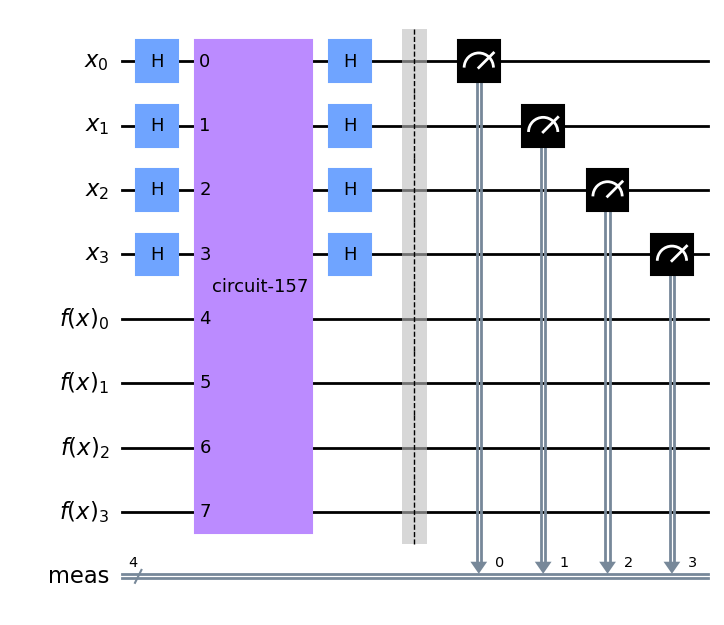

In [7]:
f_outputs = ['1111', '1011', '0011', '1000', '0101', '0100', 
               '0000', '1110', '0101', '0100', '0000', '1110', 
               '1111', '1011', '0011', '1000']

oracle = tQ.binary_function(f_outputs)
simon_qc = simon_circuit(oracle)
simon_qc.draw('mpl')

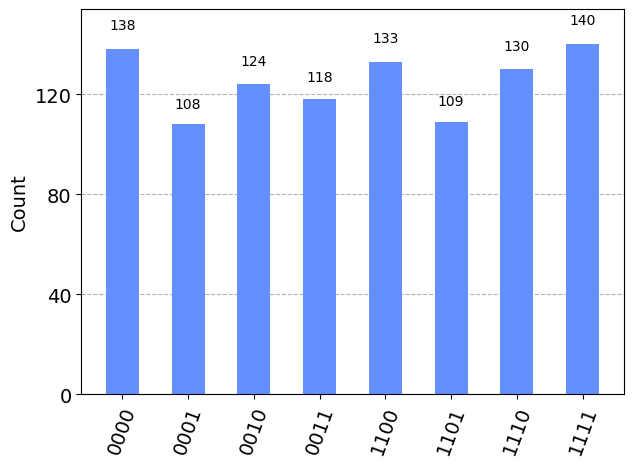

In [8]:
nshots = 1000

dist = Sampler().run(simon_qc,shots=nshots).result().quasi_dists[0]
counts_simon = tQ.dist2counts(dist,n,nshots)

from qiskit.visualization import plot_histogram
plot_histogram(counts_simon)

In [9]:
def extract_period(counts):
    'extraemos la longitud de las cuentas y que será igual a la de la incógnita s'
    n = len(list(counts)[0]) 

    'generamos todas las posibles periodicidades s'
    s_list = [format(i, 'b').zfill(n) for i in range(1, 2**n)]
#    s_list = [format(i, '0'+str(n)+'b') for i in range(1, 2**n)]  # otra manera de hacer lo mismo
#    print(s_list)

    'ahora evaluamos, para cada s,  s.y_i = 0 con todos los y_i encontrados'
    for s_str in s_list:
        s = [int(_) for _ in list(s_str)]
#        print(' s=',s)

        'solo necesitamos n valores de x independientes'
        prod_sxi = [sum([s[j]*int(xi[j]) for j in range(len(s))])%2 for xi in list(counts)[:]]

        'la suma será = 0 si y sólo si todos los s.x_i = 0 lo son también' 
        sum_sx = sum(prod_sxi)
        print('(Sum_i (s.x_i)%2))=', sum_sx, ' para s=', s_str)
        if  sum_sx==0:
            return s_str
 

In [10]:
s_sol = extract_period(counts_simon)
print('la periodicidad buscada es =', s_sol)

(Sum_i (s.x_i)%2))= 4  para s= 0001
(Sum_i (s.x_i)%2))= 4  para s= 0010
(Sum_i (s.x_i)%2))= 4  para s= 0011
(Sum_i (s.x_i)%2))= 4  para s= 0100
(Sum_i (s.x_i)%2))= 4  para s= 0101
(Sum_i (s.x_i)%2))= 4  para s= 0110
(Sum_i (s.x_i)%2))= 4  para s= 0111
(Sum_i (s.x_i)%2))= 4  para s= 1000
(Sum_i (s.x_i)%2))= 4  para s= 1001
(Sum_i (s.x_i)%2))= 4  para s= 1010
(Sum_i (s.x_i)%2))= 4  para s= 1011
(Sum_i (s.x_i)%2))= 0  para s= 1100
la periodicidad buscada es = 1100


In [11]:
def simon_oracle(s):   
    'autor Sergio Barrera'  

    def suma_mod2(a, b):    
        suma = ''
        for i in range(len(a)):
            suma += str((int(a[i]) + int(b[i])) % 2)
        return suma

    n = len(s) 
    inputs  = [format(i, 'b').zfill(n) for i in range(2**n)]
    aux = []
    f_outputs = []    
    for inp in inputs:
        if inp in [suma_mod2(a, s) for a in aux]:
            old = [a for a in aux if suma_mod2(a, s) == inp][0]
            f_outputs.append(old)
        else:
            f_outputs.append(inp)
            aux.append(inp)
    print(f_outputs)
    return tQ.binary_function(f_outputs)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '0010', '0011', '0000', '0001', '0110', '0111', '0100', '0101']


/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


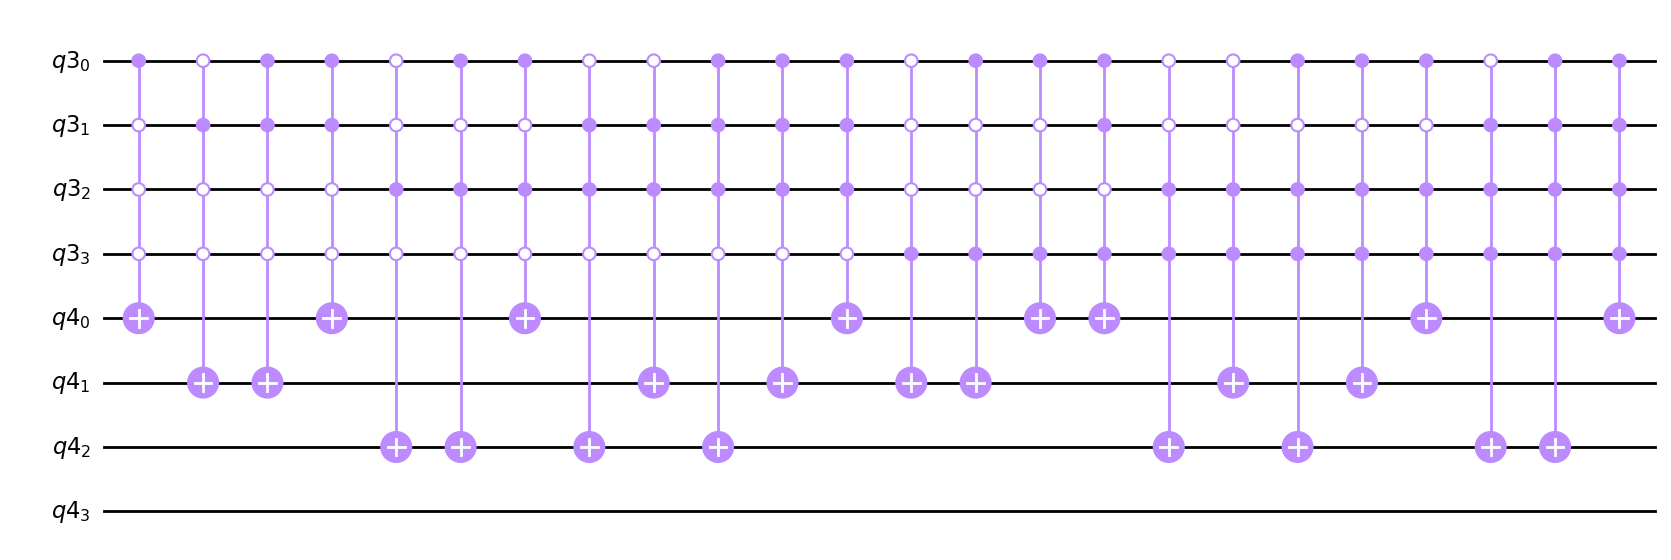

In [12]:
simon_oracle('1010').draw('mpl')